# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [20]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sns
import warnings
import time


from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Подготовка данных

In [21]:
data = pd.read_csv('autos.csv')
data.columns = data.columns.str.lower() 
data['age'] = 2020 - data['registrationyear']
data = data.drop(['datecrawled', 'datecreated', 'lastseen', 'registrationmonth', 'registrationyear', 'postalcode', 'numberofpictures'], axis=1)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   price        354369 non-null  int64 
 1   vehicletype  316879 non-null  object
 2   gearbox      334536 non-null  object
 3   power        354369 non-null  int64 
 4   model        334664 non-null  object
 5   kilometer    354369 non-null  int64 
 6   fueltype     321474 non-null  object
 7   brand        354369 non-null  object
 8   notrepaired  283215 non-null  object
 9   age          354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,price,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired,age
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,27
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,9
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,16
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,19
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,12



Удалил столбцы (даты скачивания, дата создание анкеты, дата последней активности пользователя, месяц регистрации, почтовый индекс, кол-во фотографий) эти данные никак не помогут нам при обучении.

In [22]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   price        245814 non-null  int64 
 1   vehicletype  245814 non-null  object
 2   gearbox      245814 non-null  object
 3   power        245814 non-null  int64 
 4   model        245814 non-null  object
 5   kilometer    245814 non-null  int64 
 6   fueltype     245814 non-null  object
 7   brand        245814 non-null  object
 8   notrepaired  245814 non-null  object
 9   age          245814 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.6+ MB


### Аргумент по удалению пропусков
В колонках ('vehicletype', 'gearbox', 'model', 'fueltype') пропущеных данных для каждого менее 10% и их можно удалить.<br>
А вот ситуация с колонкой 'notrepaired' другая, там много пропущеных данных, но мы не можем их заполнить тк там есть оба класса 0(no) и 1(yes).

Границы выбросв от: 0 До: 25503.0


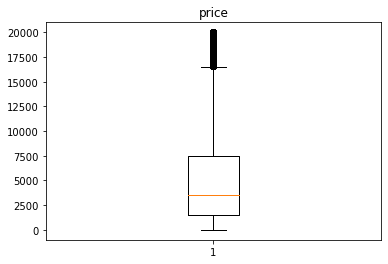

Границы выбросв от: 50000.0 До: 225000.0


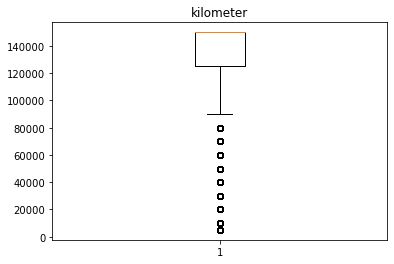

Границы выбросв от: 0 До: 375.0


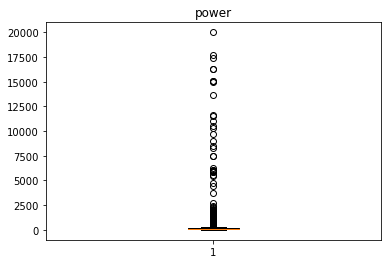

Границы выбросв от: 0 До: 45.0


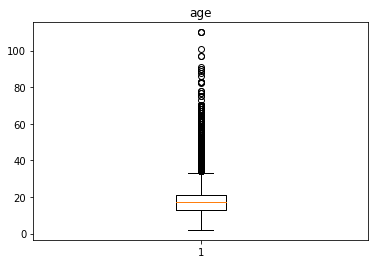

In [23]:
columns_anomaly_check = ['price', 'kilometer', 'power', 'age']


for column in columns_anomaly_check:
    Q1 = np.quantile(data[column] ,q = 0.25)
    Q3 = np.quantile(data[column] ,q = 0.75)
    
    IQR = Q3 - Q1 

    first_border = Q1 - 3 * IQR
    second_border = Q3 + 3 * IQR
    
    if first_border < 0:
        first_border = 0
    
    print('Границы выбросв от:', first_border, 'До:', second_border)
    plt.title(column)
    plt.boxplot(data[column])
    plt.show()

    
    data[column] = data[(data[column] < second_border)&(data[column] > first_border)][column]


In [24]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214798 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        214798 non-null  float64
 1   vehicletype  214798 non-null  object 
 2   gearbox      214798 non-null  object 
 3   power        214798 non-null  float64
 4   model        214798 non-null  object 
 5   kilometer    214798 non-null  float64
 6   fueltype     214798 non-null  object 
 7   brand        214798 non-null  object 
 8   notrepaired  214798 non-null  object 
 9   age          214798 non-null  float64
dtypes: float64(4), object(6)
memory usage: 18.0+ MB


In [25]:
target = data['price']
features = data.drop(['price'], axis=1)

In [26]:
encoder = OrdinalEncoder()
encoder.fit(features)
features = pd.DataFrame(encoder.transform(features), columns=features.columns)
features

,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired,age
0,5.0,1.0,70.0,116.0,6.0,6.0,37.0,0.0,17.0
1,5.0,1.0,64.0,101.0,3.0,2.0,31.0,0.0,10.0
2,4.0,1.0,97.0,11.0,6.0,6.0,2.0,1.0,23.0
3,1.0,1.0,104.0,8.0,6.0,6.0,25.0,0.0,14.0
4,4.0,1.0,100.0,10.0,6.0,6.0,19.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...
214793,4.0,1.0,135.0,116.0,6.0,2.0,37.0,0.0,8.0
214794,7.0,1.0,2.0,11.0,6.0,2.0,2.0,0.0,13.0
214795,4.0,1.0,220.0,140.0,6.0,6.0,30.0,1.0,14.0
214796,1.0,0.0,96.0,106.0,5.0,6.0,32.0,0.0,18.0


Закодировал данные методом OrdinalEncoder.

## Обучение моделей

In [27]:
def make_features(features, target):
    features = features
    target =  target

    features_train, features_test, target_train, target_test = train_test_split(
                                        features, target, test_size=0.25, random_state=666)
    
    
    
    return features_train, features_test, target_train, target_test


def learn_model(models, features_train, features_test, target_train, target_test, title=''):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'MAE': mean_absolute_error,
                   'r2' : r2_score
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn = models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=5, param_grid=params, n_jobs=-1)
            grid.fit(features_train, target_train)
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


In [28]:
features_train, features_test, target_train, target_test = make_features(features, target)

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(161098, 9) (161098,)
(53700, 9) (53700,)


In [29]:
models = {'Linear' : [LinearRegression(n_jobs=-1), {}],
          
          'Forest' : [RandomForestRegressor(n_jobs=-1), {'max_depth':range(1, 10, 4),
                                                         'min_samples_leaf':range(1, 7, 3),
                                                         'n_estimators':range(10, 110, 35)}],
          'LightGBM' : [LGBMRegressor(n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                   'max_depth':range(1, 15, 1),
                                                   'n_estimators':range(1, 101, 25)}],
          
          'CatBoost' : [CatBoostRegressor(silent=True, iterations=40), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                          'depth':range(1, 15, 1)}]
         }

__________Linear__________
           train         test
MAE  1923.284523  1928.013241
r2      0.647336     0.645192

__________Forest__________
           train         test
MAE  1181.694882  1212.773541
r2      0.843327     0.832607

__________LightGBM__________
           train         test
MAE  1029.374199  1043.025242
r2      0.875513     0.871723

__________CatBoost__________
           train         test
MAE  1018.000922  1048.094509
r2      0.880698     0.871581



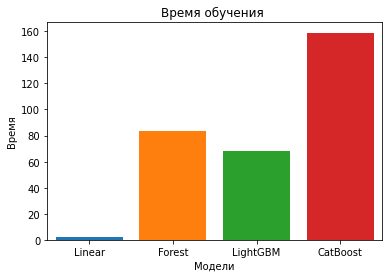

Wall time: 5min 13s


In [30]:
%%time
models_rougher = learn_model(models, features_train, features_test, target_train, target_test)

## Вывод
Модель градиентного бустинга LightGBM лучше справляется со своей задачей.
1. У нее быстрая скорость обучения по сравнению с CatBoost.
2. Высокая скорость предсказания.  
3. Качество предсказаний.

Так в свою очередь величина ошибка простой линейной регрессии нивелирует ее скорость обучения и предсказания.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей